# Basics

## Quickstart
### Working with data
PyTorch has two primitives to work with data: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the `Dataset`.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as
[TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and
[TorchAudio](https://pytorch.org/audio/stable/index.html), all of which
include datasets. For this tutorial, we will be using a TorchVision
dataset.

The `torchvision.datasets` module contains `Dataset` objects for many
real-world vision data like CIFAR, COCO ([full list
here](https://pytorch.org/vision/stable/datasets.html)). In this
tutorial, we use the FashionMNIST dataset. Every TorchVision `Dataset`
includes two arguments: `transform` and `target_transform` to modify the
samples and labels respectively.

In [ ]:
# Download training data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:03<00:00, 7967741.55it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209638.13it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 681541.68it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5331426.42it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



We pass the `Dataset` as an argument to `DataLoader`. This wraps an
iterable over our dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.


In [ ]:
batch_size = 64

# create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Creating Models

To define a neural network in PyTorch, we create a class that inherits from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network in the `__init__` function and
specify how data will pass through the network in the `forward`
function. To accelerate operations in the neural network, we move it to the GPU or MPS if available.


In [ ]:
# Get cpu, gpu or mps device for training
device = ("cuda" if torch.cuda.is_available()
          else "cpu")
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stak = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stak(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stak): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) and an [optimizer](https://pytorch.org/docs/stable/optim.html).


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model\'s parameters.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

We also check the model\'s performance against the test dataset to
ensure it is learning.

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*).
During each epoch, the model learns parameters to make better
predictions. We print the model\'s accuracy and loss at each epoch;
we\'d like to see the accuracy increase and the loss decrease with every
epoch.


In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.312702 [   64/60000]
loss: 2.302686 [ 6464/60000]
loss: 2.273867 [12864/60000]
loss: 2.261350 [19264/60000]
loss: 2.255846 [25664/60000]
loss: 2.224161 [32064/60000]
loss: 2.225834 [38464/60000]
loss: 2.197489 [44864/60000]
loss: 2.193152 [51264/60000]
loss: 2.153397 [57664/60000]
Test Error: 
 Accuracy: 35.4%, Avg loss: 2.156094 

Epoch 2
-------------------------------
loss: 2.177377 [   64/60000]
loss: 2.168272 [ 6464/60000]
loss: 2.102842 [12864/60000]
loss: 2.112488 [19264/60000]
loss: 2.071274 [25664/60000]
loss: 2.012736 [32064/60000]
loss: 2.037289 [38464/60000]
loss: 1.961162 [44864/60000]
loss: 1.961603 [51264/60000]
loss: 1.890148 [57664/60000]
Test Error: 
 Accuracy: 49.2%, Avg loss: 1.888956 

Epoch 3
-------------------------------
loss: 1.933108 [   64/60000]
loss: 1.903405 [ 6464/60000]
loss: 1.777747 [12864/60000]
loss: 1.816611 [19264/60000]
loss: 1.707883 [25664/60000]
loss: 1.663428 [32064/60000]
loss: 1.687826 [38464/

### Saving Models
A common way to save a model is to serialize the internal state
dictionary (containing the model parameters).

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

### Loading models
The process for loading a model includes re-creating the model structure and loading the state dictionary into it.


In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

This model can now be used to make predictions.

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

## Tensors
Like array, but can run on GPU.

In [ ]:
import torch
import numpy as np

### Initializing Tensor
Directly from data

In [ ]:
data = [[1, 2], [3, 4]]
print(data)
x_data = torch.tensor(data)
print(x_data)

[[1, 2], [3, 4]]
tensor([[1, 2],
        [3, 4]])


**From numpy array.**

In [ ]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

**From another tensor**, new tensor keep shape and datatype of old tensor.

In [ ]:
x_ones = torch.ones_like(x_data) # retains properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides dtype
print(f"Ones Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Ones Tensor: 
 tensor([[0.2128, 0.8975],
        [0.8850, 0.3905]]) 



**With random or constant values:**

`shape` is a tuple of tensor dimensions. In the functions below, it
determines the dimensionality of the output tensor.

In [ ]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.5674, 0.6799, 0.2115],
        [0.6086, 0.1519, 0.2078]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


### Attributes of a Tensor

Tensor attributes describe their shape, datatype, and the device on
which they are stored.

In [ ]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


### Tensor operations

In [ ]:
# We move our tensor to the GPU if available
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

In [ ]:
tensor = torch.rand(4, 4)
print(f"First row: {tensor[0, :]}")
print(f"First column: {tensor[:,0]}")
print(f"Last column: {tensor[...,-1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([0.8542, 0.7970, 0.1524, 0.4318])
First column: tensor([0.8542, 0.9904, 0.2437, 0.6107])
Last column: tensor([0.4318, 0.7757, 0.8978, 0.2656])
tensor([[0.8542, 0.0000, 0.1524, 0.4318],
        [0.9904, 0.0000, 0.5376, 0.7757],
        [0.2437, 0.0000, 0.2167, 0.8978],
        [0.6107, 0.0000, 0.6186, 0.2656]])


**Joining tensors** `torch.cat` to concatenate tensors.

In [ ]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[0.8542, 0.0000, 0.1524, 0.4318, 0.8542, 0.0000, 0.1524, 0.4318, 0.8542,
         0.0000, 0.1524, 0.4318],
        [0.9904, 0.0000, 0.5376, 0.7757, 0.9904, 0.0000, 0.5376, 0.7757, 0.9904,
         0.0000, 0.5376, 0.7757],
        [0.2437, 0.0000, 0.2167, 0.8978, 0.2437, 0.0000, 0.2167, 0.8978, 0.2437,
         0.0000, 0.2167, 0.8978],
        [0.6107, 0.0000, 0.6186, 0.2656, 0.6107, 0.0000, 0.6186, 0.2656, 0.6107,
         0.0000, 0.6186, 0.2656]])


**Arithmatic operations**

In [ ]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)


# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

**Single-element tensors** If you have a one-element tensor, for example
by aggregating all values of a tensor into one value, you can convert it
to a Python numerical value using `item()`:


In [ ]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

**In-place operations** Operations that store the result into the
operand are called in-place. They are denoted by a `_` suffix. For
example: `x.copy_(y)`, `x.t_()`, will change `x`.


In [ ]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

### Bridge with numpy
Tensors on the CPU and NumPy arrays can share their underlying memory
locations, and changing one will change the other.


**Tensor to NumPy array**

In [ ]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

n = np.ones(5)
t = torch.from_numpy(n)

## Datasets and Dataloaders

Code for processing data samples can get messy and hard to maintain; we
ideally want our dataset code to be decoupled from our model training
code for better readability and modularity. PyTorch provides two data
primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`
that allow you to use pre-loaded datasets as well as your own data.
`Dataset` stores the samples and their corresponding labels, and
`DataLoader` wraps an iterable around the `Dataset` to enable easy
access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such
as FashionMNIST) that subclass `torch.utils.data.Dataset` and implement
functions specific to the particular data. They can be used to prototype
and benchmark your model. You can find them here: [Image
Datasets](https://pytorch.org/vision/stable/datasets.html), [Text
Datasets](https://pytorch.org/text/stable/datasets.html), and [Audio
Datasets](https://pytorch.org/audio/stable/datasets.html)

### Loading a Dataset
Here is an example of how to load the
[Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/)
dataset from TorchVision. Fashion-MNIST is a dataset of Zalando's
article images consisting of 60,000 training examples and 10,000 test
examples. Each example comprises a 28×28 grayscale image and an
associated label from one of 10 classes.

We load the [FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) with the following parameters:

:   -   `root` is the path where the train/test data is stored,
    -   `train` specifies training or test dataset,
    -   `download=True` downloads the data from the internet if it\'s
        not available at `root`.
    -   `transform` and `target_transform` specify the feature and label
        transformations


In [ ]:
%matplotlib inline

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### Iterating and Visualizing the Dataset

We can index `Datasets` manually like a list: `training_data[index]`. We
use `matplotlib` to visualize some samples in our training data.


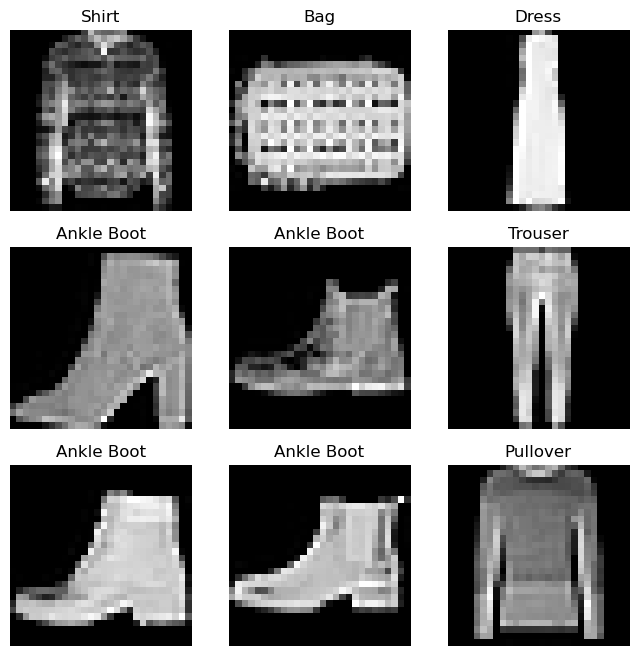

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating a Custom Dataset for your files

A custom Dataset class must implement three functions:
[\_\_init\_\_]{.title-ref}, [\_\_len\_\_]{.title-ref}, and
[\_\_getitem\_\_]{.title-ref}. Take a look at this implementation; the
FashionMNIST images are stored in a directory `img_dir`, and their
labels are stored separately in a CSV file `annotations_file`.

In the next sections, we\'ll break down what\'s happening in each of
these functions.


In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

`__init__`

The \_\_[init]() function is run once when instantiating the Dataset
object. We initialize the directory containing the images, the
annotations file, and both transforms (covered in more detail in the
next section).

The labels.csv file looks like: :

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9

`__len__`

The \_\_[len]() function returns the number of samples in our dataset.

`__getitem__`

The \_\_[getitem]() function loads and returns a sample from the dataset
at the given index `idx`. Based on the index, it identifies the image\'s
location on disk, converts that to a tensor using `read_image`,
retrieves the corresponding label from the csv data in
`self.img_labels`, calls the transform functions on them (if
applicable), and returns the tensor image and corresponding label in a
tuple.


### Preparing your data for training with DataLoaders

The `Dataset` retrieves our dataset\'s features and labels one sample at
a time. While training a model, we typically want to pass samples in
\"minibatches\", reshuffle the data at every epoch to reduce model
overfitting, and use Python\'s `multiprocessing` to speed up data
retrieval.

`DataLoader` is an iterable that abstracts this complexity for us in an
easy API.


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterate through the DataLoader

We have loaded that dataset into the `DataLoader` and can iterate
through the dataset as needed. Each iteration below returns a batch of
`train_features` and `train_labels` (containing `batch_size=64` features
and labels respectively). Because we specified `shuffle=True`, after we
iterate over all batches the data is shuffled (for finer-grained control
over the data loading order, take a look at
[Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)).


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


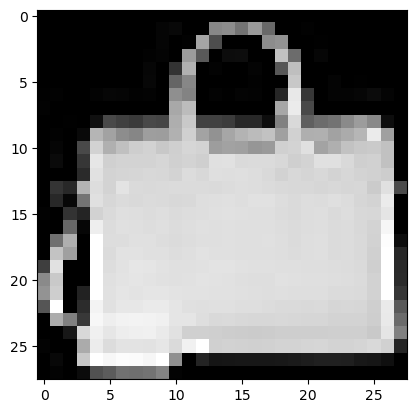

Label: 8


In [ ]:
# Display image and label.

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Transforms

Data does not always come in its final processed form that is required
for training machine learning algorithms. We use **transforms** to
perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters -`transform` to modify the
features and `target_transform` to modify the labels - that accept
callables containing the transformation logic. The
[torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)
module offers several commonly-used transforms out of the box.

The FashionMNIST features are in PIL Image format, and the labels are
integers. For training, we need the features as normalized tensors, and
the labels as one-hot encoded tensors. To make these transformations, we
use `ToTensor` and `Lambda`.

### ToTensor()

[ToTensor](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor)
converts a PIL image or NumPy `ndarray` into a `FloatTensor`. and scales
the image\'s pixel intensity values in the range \[0., 1.\]

### Lambda Transforms

Lambda transforms apply any user-defined lambda function. Here, we
define a function to turn the integer into a one-hot encoded tensor. It
first creates a zero tensor of size 10 (the number of labels in our
dataset) and calls
[scatter\_](https://pytorch.org/docs/stable/generated/torch.Tensor.scatter_.html)
which assigns a `value=1` on the index as given by the label `y`.


In [ ]:
%matplotlib inline

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

## Build Model
### Build the Neural Network

Neural networks comprise of layers/modules that perform operations on
data. The [torch.nn](https://pytorch.org/docs/stable/nn.html) namespace
provides all the building blocks you need to build your own neural
network. Every module in PyTorch subclasses the
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
A neural network is a module itself that consists of other modules
(layers). This nested structure allows for building and managing complex
architectures easily.

In the following sections, we\'ll build a neural network to classify
images in the FashionMNIST dataset.


In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Define the Class

We define our neural network by subclassing `nn.Module`, and initialize
the neural network layers in `__init__`. Every `nn.Module` subclass
implements the operations on input data in the `forward` method.


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model\'s
`forward`, along with some [background
operations](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866).
Do not call `model.forward()` directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0
corresponding to each output of 10 raw predicted values for each class,
and dim=1 corresponding to the individual values of each output. We get
the prediction probabilities by passing it through an instance of the
`nn.Softmax` module.


In [ ]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([4], device='cuda:0')


### Model Layers

Let\'s break down the layers in the FashionMNIST model. To illustrate
it, we will take a sample minibatch of 3 images of size 28x28 and see
what happens to it as we pass it through the network.


In [ ]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten

We initialize the
[nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)
layer to convert each 2D 28x28 image into a contiguous array of 784
pixel values ( the minibatch dimension (at dim=0) is maintained).


In [ ]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear

The [linear
layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
is a module that applies a linear transformation on the input using its
stored weights and biases.


In [ ]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### nn.ReLU

Non-linear activations are what create the complex mappings between the
model\'s inputs and outputs. They are applied after linear
transformations to introduce *nonlinearity*, helping neural networks
learn a wide variety of phenomena.

In this model, we use
[nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
between our linear layers, but there\'s other activations to introduce
non-linearity in your model.


In [ ]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-3.1540e-02, -1.5555e-01, -4.0794e-01, -1.6999e-01, -6.4646e-02,
         -1.9358e-01, -2.2942e-01, -3.8007e-02, -3.2575e-01, -3.3794e-01,
         -2.9540e-01, -1.9502e-01, -1.8220e-01,  4.0613e-02,  2.2113e-02,
          5.2996e-02, -3.3352e-02,  3.4086e-01, -3.0559e-02, -2.6503e-01],
        [-3.4629e-01,  6.6547e-02, -7.7879e-01, -2.7901e-01, -4.9018e-02,
         -4.3725e-01,  1.1751e-01, -3.2069e-01, -4.1478e-01,  7.1298e-02,
          3.0193e-01, -6.1575e-02, -2.5639e-01,  6.4421e-02, -2.6663e-01,
         -1.1187e-04, -2.1553e-01,  2.7886e-01,  1.7046e-01, -3.3301e-01],
        [-3.1233e-01,  4.5994e-01, -4.7507e-01, -2.7212e-02, -6.2979e-02,
         -2.8331e-01, -2.6563e-01, -2.7401e-01, -9.3969e-02,  2.5433e-01,
         -1.8697e-01,  1.0256e-02, -3.3530e-01,  8.3531e-03,  2.2403e-01,
         -1.7757e-01,  1.4530e-01,  4.5996e-01,  6.1837e-02, -4.3811e-01]],
       grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

### nn.Sequential

[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
is an ordered container of modules. The data is passed through all the
modules in the same order as defined. You can use sequential containers
to put together a quick network like `seq_modules`.


In [ ]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

### nn.Softmax

The last linear layer of the neural network returns [logits]{.title-ref}
- raw values in \[-infty, infty\] - which are passed to the
[nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
module. The logits are scaled to values \[0, 1\] representing the
model\'s predicted probabilities for each class. `dim` parameter
indicates the dimension along which the values must sum to 1.


In [ ]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

### Model Parameters

Many layers inside a neural network are *parameterized*, i.e. have
associated weights and biases that are optimized during training.
Subclassing `nn.Module` automatically tracks all fields defined inside
your model object, and makes all parameters accessible using your
model\'s `parameters()` or `named_parameters()` methods.

In this example, we iterate over each parameter, and print its size and
a preview of its values.


In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0348, -0.0308, -0.0048,  ...,  0.0120,  0.0327,  0.0125],
        [ 0.0046,  0.0287,  0.0287,  ...,  0.0183, -0.0086,  0.0185]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0026, -0.0231], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0196, -0.0005, -0.0050,  ...,  0.0310, -0.0013, -0.0398],
        [-0.0090,  0.0228, -0.0256,  ..., -0.0274,  0.0072, -0.0119]],
       device='cuda:0', grad_fn=<Sl

## Automatic Differentiation with `torch.autograd`

When training neural networks, the most frequently used algorithm is
**back propagation**. In this algorithm, parameters (model weights) are
adjusted according to the **gradient** of the loss function with respect
to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation
engine called `torch.autograd`. It supports automatic computation of
gradient for any computational graph.

Consider the simplest one-layer neural network, with input `x`,
parameters `w` and `b`, and some loss function. It can be defined in
PyTorch in the following manner:


In [ ]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

### Tensors, Functions and Computational graph

This code defines the following **computational graph**:

![](https://pytorch.org/tutorials/_static/img/basics/comp-graph.png)

In this network, `w` and `b` are **parameters**, which we need to
optimize. Thus, we need to be able to compute the gradients of loss
function with respect to those variables. In order to do that, we set
the `requires_grad` property of those tensors.


A function that we apply to tensors to construct computational graph is
in fact an object of class `Function`. This object knows how to compute
the function in the *forward* direction, and also how to compute its
derivative during the *backward propagation* step. A reference to the
backward propagation function is stored in `grad_fn` property of a
tensor. You can find more information of `Function` [in the
documentation](https://pytorch.org/docs/stable/autograd.html#function).


In [ ]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7a3bec6c97e0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7a3bec6c9600>


### Computing Gradients

To optimize weights of parameters in the neural network, we need to
compute the derivatives of our loss function with respect to parameters,
namely, we need $\frac{\partial loss}{\partial w}$ and
$\frac{\partial loss}{\partial b}$ under some fixed values of `x` and
`y`. To compute those derivatives, we call `loss.backward()`, and then
retrieve the values from `w.grad` and `b.grad`:


In [ ]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.3007, 0.3030, 0.2859],
        [0.3007, 0.3030, 0.2859],
        [0.3007, 0.3030, 0.2859],
        [0.3007, 0.3030, 0.2859],
        [0.3007, 0.3030, 0.2859]])
tensor([0.3007, 0.3030, 0.2859])


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<ul>
<li>We can only obtain the <code>grad</code> properties for the leafnodes of the computational graph, which have <code>requires_grad</code> propertyset to <code>True</code>. For all other nodes in our graph, gradients will not beavailable.- We can only perform gradient calculations using<code>backward</code> once on a given graph, for performance reasons. If we needto do several <code>backward</code> calls on the same graph, we need to pass<code>retain_graph=True</code> to the <code>backward</code> call.</li>
</ul>
</div>


### Disabling Gradient Tracking

By default, all tensors with `requires_grad=True` are tracking their
computational history and support gradient computation. However, there
are some cases when we do not need to do that, for example, when we have
trained the model and just want to apply it to some input data, i.e. we
only want to do *forward* computations through the network. We can stop
tracking computations by surrounding our computation code with
`torch.no_grad()` block:


In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


Another way to achieve the same result is to use the `detach()` method
on the tensor:


In [ ]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


There are reasons you might want to disable gradient tracking:

:   -   To mark some parameters in your neural network as **frozen
        parameters**.
    -   To **speed up computations** when you are only doing forward
        pass, because computations on tensors that do not track
        gradients would be more efficient.


### More on Computational Graphs

Conceptually, autograd keeps a record of data (tensors) and all executed
operations (along with the resulting new tensors) in a directed acyclic
graph (DAG) consisting of
[Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
objects. In this DAG, leaves are the input tensors, roots are the output
tensors. By tracing this graph from roots to leaves, you can
automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

-   run the requested operation to compute a resulting tensor
-   maintain the operation's *gradient function* in the DAG.

The backward pass kicks off when `.backward()` is called on the DAG
root. `autograd` then:

-   computes the gradients from each `.grad_fn`,
-   accumulates them in the respective tensor's `.grad` attribute
-   using the chain rule, propagates all the way to the leaf tensors.

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>An important thing to note is that the graph is recreated from scratch; after each<code>.backward()</code> call, autograd starts populating a new graph. This isexactly what allows you to use control flow statements in your model;you can change the shape, size and operations at every iteration ifneeded.</p>
</div>


### Optional Reading: Tensor Gradients and Jacobian Products

In many cases, we have a scalar loss function, and we need to compute
the gradient with respect to some parameters. However, there are cases
when the output function is an arbitrary tensor. In this case, PyTorch
allows you to compute so-called **Jacobian product**, and not the actual
gradient.

For a vector function $\vec{y}=f(\vec{x})$, where
$\vec{x}=\langle x_1,\dots,x_n\rangle$ and
$\vec{y}=\langle y_1,\dots,y_m\rangle$, a gradient of $\vec{y}$ with
respect to $\vec{x}$ is given by **Jacobian matrix**:

$$\begin{aligned}
J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)
\end{aligned}$$

Instead of computing the Jacobian matrix itself, PyTorch allows you to
compute **Jacobian Product** $v^T\cdot J$ for a given input vector
$v=(v_1 \dots v_m)$. This is achieved by calling `backward` with $v$ as
an argument. The size of $v$ should be the same as the size of the
original tensor, with respect to which we want to compute the product:


In [ ]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


Notice that when we call `backward` for the second time with the same
argument, the value of the gradient is different. This happens because
when doing `backward` propagation, PyTorch **accumulates the
gradients**, i.e. the value of computed gradients is added to the `grad`
property of all leaf nodes of computational graph. If you want to
compute the proper gradients, you need to zero out the `grad` property
before. In real-life training an *optimizer* helps us to do this.


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>Previously we were calling <code>backward()</code> function withoutparameters. This is essentially equivalent to calling<code>backward(torch.tensor(1.0))</code>, which is a useful way to compute thegradients in case of a scalar-valued function, such as loss duringneural network training.</p>
</div>


## Optimization Loop

### Optimizing Model Parameters

Now that we have a model and data it\'s time to train, validate and test
our model by optimizing its parameters on our data. Training a model is
an iterative process; in each iteration the model makes a guess about
the output, calculates the error in its guess (*loss*), collects the
derivatives of the error with respect to its parameters (as we saw in
the [previous section](autograd_tutorial.html)), and **optimizes** these
parameters using gradient descent. For a more detailed walkthrough of
this process, check out this video on [backpropagation from
3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

Prerequisite Code
-----------------

We load the code from the previous sections on [Datasets &
DataLoaders](data_tutorial.html) and [Build
Model](buildmodel_tutorial.html).


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

### Hyperparameters

Hyperparameters are adjustable parameters that let you control the model
optimization process. Different hyperparameter values can impact model
training and convergence rates ([read
more](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)
about hyperparameter tuning)

We define the following hyperparameters for training:

:   -   **Number of Epochs** - the number times to iterate over the
        dataset
    -   **Batch Size** - the number of data samples propagated through
        the network before the parameters are updated
    -   **Learning Rate** - how much to update models parameters at each
        batch/epoch. Smaller values yield slow learning speed, while
        large values may result in unpredictable behavior during
        training.


In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

### Optimization Loop

Once we set our hyperparameters, we can then train and optimize our
model with an optimization loop. Each iteration of the optimization loop
is called an **epoch**.

Each epoch consists of two main parts:

:   -   **The Train Loop** - iterate over the training dataset and try
        to converge to optimal parameters.
    -   **The Validation/Test Loop** - iterate over the test dataset to
        check if model performance is improving.

Let\'s briefly familiarize ourselves with some of the concepts used in
the training loop. Jump ahead to see the
`full-impl-label`{.interpreted-text role="ref"} of the optimization
loop.

#### Loss Function

When presented with some training data, our untrained network is likely
not to give the correct answer. **Loss function** measures the degree of
dissimilarity of obtained result to the target value, and it is the loss
function that we want to minimize during training. To calculate the loss
we make a prediction using the inputs of our given data sample and
compare it against the true data label value.

Common loss functions include
[nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)
(Mean Square Error) for regression tasks, and
[nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss)
(Negative Log Likelihood) for classification.
[nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)
combines `nn.LogSoftmax` and `nn.NLLLoss`.

We pass our model\'s output logits to `nn.CrossEntropyLoss`, which will
normalize the logits and compute the prediction error.


In [ ]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

Optimization is the process of adjusting model parameters to reduce
model error in each training step. **Optimization algorithms** define
how this process is performed (in this example we use Stochastic
Gradient Descent). All optimization logic is encapsulated in the
`optimizer` object. Here, we use the SGD optimizer; additionally, there
are many [different
optimizers](https://pytorch.org/docs/stable/optim.html) available in
PyTorch such as ADAM and RMSProp, that work better for different kinds
of models and data.

We initialize the optimizer by registering the model\'s parameters that
need to be trained, and passing in the learning rate hyperparameter.


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:

:   -   Call `optimizer.zero_grad()` to reset the gradients of model
        parameters. Gradients by default add up; to prevent
        double-counting, we explicitly zero them at each iteration.
    -   Backpropagate the prediction loss with a call to
        `loss.backward()`. PyTorch deposits the gradients of the loss
        w.r.t. each parameter.
    -   Once we have our gradients, we call `optimizer.step()` to adjust
        the parameters by the gradients collected in the backward pass.


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.295837  [   64/60000]
loss: 2.293579  [ 6464/60000]
loss: 2.272922  [12864/60000]
loss: 2.270849  [19264/60000]
loss: 2.263756  [25664/60000]
loss: 2.222189  [32064/60000]
loss: 2.237807  [38464/60000]
loss: 2.196224  [44864/60000]
loss: 2.189372  [51264/60000]
loss: 2.169547  [57664/60000]
Test Error: 
 Accuracy: 37.8%, Avg loss: 2.157363 

Epoch 2
-------------------------------
loss: 2.157923  [   64/60000]
loss: 2.159187  [ 6464/60000]
loss: 2.095220  [12864/60000]
loss: 2.115452  [19264/60000]
loss: 2.085444  [25664/60000]
loss: 2.005141  [32064/60000]
loss: 2.042828  [38464/60000]
loss: 1.950053  [44864/60000]
loss: 1.950055  [51264/60000]
loss: 1.900573  [57664/60000]
Test Error: 
 Accuracy: 60.7%, Avg loss: 1.886302 

Epoch 3
-------------------------------
loss: 1.903745  [   64/60000]
loss: 1.892251  [ 6464/60000]
loss: 1.762474  [12864/60000]
loss: 1.813374  [19264/60000]
loss: 1.737207  [25664/60000]
loss: 1.656015  [32064/600

## Save, Load and Use Model

In [ ]:
import torch
import torchvision.models as models

### Saving and Loading Model Weights

PyTorch models store the learned parameters in an internal state
dictionary, called `state_dict`. These can be persisted via the
`torch.save` method:

In [ ]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/sunzid/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:15<00:00, 35.8MB/s] 


To load model weights, you need to create an instance of the same model
first, and then load the parameters using `load_state_dict()` method.


In [ ]:
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>be sure to call <code>model.eval()</code> method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.</p>
</div>


### Saving and Loading Models with Shapes

When loading model weights, we needed to instantiate the model class
first, because the class defines the structure of a network. We might
want to save the structure of this class together with the model, in
which case we can pass `model` (and not `model.state_dict()`) to the
saving function:


In [ ]:
torch.save(model, 'model.pth')

In [ ]:
model = torch.load('model.pth')

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>This approach uses Python <a href="https://docs.python.org/3/library/pickle.html">pickle</a> module when serializing the model, thus it relies on the actual class definition to be available when loading the model.</p>
</div>


# Freecodecamp Tutorial

## Basics
### Machine Learning
Turning things (data) into numbers, and finding patterns in those numbers.

Machine learning for structured data:
- Random forest
- Gradient boosted models
- Naive Bayes
- Nearest neighbour
- Support vector machine
- XGBoost, etc.


### Deep Learning
Deep learning for unstructured data:
- Neural networks.
- Fully connected neural networks
- Convolutional neural network
- Recurrent neural network
- Transformer, etc.

### Neural Networks
Input > numeric encoding > neural network (input layer > hidden layer(s) > ourput layer) to learn representation (patterns/embeddings/features/weights) > learned representation > prediction probabilities.

Each layer is combination of linear/non-linear functions, and it's like what patterns we can draw using many lines. 

### Types of learning
Supervised (we have data-label), unsupervised and self-supervised (unlabelled data), transfer learning, reinforcement learning.

### Pytorch
Research deep learning framework.

### Tensor
Input data is converted to numeric tensor. NN output is also tensor of learned representation.

Vectors can represent area - the length of the vector is equal to the area of the surface, and the direction is perpendicular to the surface.
A vector can be $4\hat{i}+3\hat{j}+0\hat{k}$ in Cartesian coordinate system is expressed using basis vectors $\hat{i}$, $\hat{j}$ and $\hat{k}$ for $x$, $y$ and $z$, and components 4, 3, and 0. The components can be used to express it as column vector $\left[\begin{array}{c}4\\3\\0\end{array}\right]$.

The column vector is rank 1, since it requires one index or basis vector per component $\mathbf{A}=\left[\begin{array}{c}A_x\\ A_y\\ A_z\end{array}\right]$. 
Scalers can be considered tensors of rank 0, as they have no directional indicators.

In a rank 2 tensor, we have 9 components, and 9 sets of 2 basis vectors. Each components has two indices. For example:
$$\mathbf{A}=
\left[\begin{array}{ccc}
A_{xx} & A_{xy} & A_{xz}\\
A_{yx} & A_{yy} & A_{yz}\\
A_{zx} & A_{zy} & A_{zz}
\end{array}\right]$$


In a rank 3 tensor, there are 27 components, each pertaining to one of 27 sets of 3 basis vectors.

Now for different reference frames, the basis vectors and components can differ, but the combination of those basis vectors and components give us same ending result.

## Course contents
- Pytorch basics & fundamentals (dealing with tensors and tensor operations)
- Preprocessing data (getting it into tensors)
-  Building and using pretrained deep learning models
- Fitting a model to the data (learning patterns)
- Making predictions with a model (using patterns)
- Evaluating model predictions
- Saving and loading models
- Using a trained model to make predictions on custom data

### PyTorch workflow
Getting data ready > Build or pick a pretrained model (pick a loss function and optimizer > build a training loop) > Fit the model to the data and make a prediction > Evaluate the model > Improve through experimentation > Save and reload the trained model.

### How to approach the course
1. Code along
2. Explore and experiment
3. Visualize what you don't understand
4. Ask questions
5. Do the exercises
6. Share your work

### Course resources
https://github.com/mrdbourke/pytorch-deep-learning  
Q&A: https://github.com/mrdbourke/pytorch-deep-learning/discussions  
Online book: learnpytorch.io

pytorch.org
PyTorch forum

## 00_pytorch_fundamentals

In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

2.2.1+cu121


In [4]:
print(torch.cuda.is_available)

<function is_available at 0x7ae5e01afa60>


### Tensors

Scalars are 0-dim - just a value, typically written with lowercase variable name.
Vectors are 1-dim - value with a direction, typically written with lowercase variable name.
MATRIX are 2-dim - set of vectors, typically written with uppercase variable name.
TENSOR are n-dim - set of n-1 dim TENSORS, typically written with uppercase variable name.

#### Creating tensors
PyTorch tensors are created using torch.tensor()

In [41]:
# Scalar
scalar = torch.tensor(7)
print(scalar)

# scalar has 0 dim
print(scalar.ndim)

# get value of the scalar
print(scalar.item())

# scalar has no shape
print(scalar.shape)

tensor(7)
0
7
torch.Size([])


In [15]:
# Vector - has magnitude and direction
vector = torch.tensor([7,7])
print(vector)

# vector dim: 1 as there are 1 pair of square brackets
print(vector.ndim)

# vector shape: is 2 as there are 2*1 elements
print(vector.shape)

tensor([7, 7])
1
torch.Size([2])


In [4]:
# MATRIX
MATRIX = torch.tensor([[7, 8],
                        [8, 9]])
print('Matrix 1:', MATRIX)

# MATRIX dimensions - 2 given 2 paris of square brackets outside
print('Matrix dim:', MATRIX.ndim)

# Accessessing different dimensions - each dimensions of the n-dim matrix has n-1 dim vectors
print('Matrix dim 1:', MATRIX[0])
print('Matrix dim 2:', MATRIX[1])

# MATRIX shape - 2 final square-bracket packets by 2 elements in each final square bracket packets
print('Matrix shape: ', MATRIX.shape)
print()

# the MATRIX has the same dim of 2, but the shape is 3 by 1 in this case
MATRIX2 = torch.tensor([[7],
                        [8],
                        [0]])
print('Matrix dim:', MATRIX2.ndim)
print('Matrix shape:', MATRIX2.shape)

Matrix 1: tensor([[7, 8],
        [8, 9]])
Matrix dim: 2
Matrix dim 1: tensor([7, 8])
Matrix dim 2: tensor([8, 9])
Matrix shape:  torch.Size([2, 2])

Matrix dim: 2
Matrix shape: torch.Size([3, 1])


In [10]:
"""
If we consider the elements inside the rightmost square-bracket at start,
there is a 3-element vector. So dim of TENSOR[0,0] is 1 and shape is 3.

Inside the second-rightmost square bracket, there are 3 vectors each with 3 elements.
So it's a 3 by 3 matrix. So the dim of TENSOR[0] is 2 and shape is 3 by 3.

Inside the leftmost square bracket, there is one set of 3 by 3 matrix.
So the dim of TENSOR is 3, and the shape is 1 by 3 by 3.
"""

# TENSOR
TENSOR = torch.tensor([[[1, 2, 3],
                        [3, 6, 9],
                        [2, 5, 4]]])
print('TENSOR:\n', TENSOR)

# TENSOR ndim is 3 - given 3 square-brackets at start
print('TENSOR dim:', TENSOR.ndim)

# Shape of this TENOSR is 3 by 3 - 3 final square-bracket packets, 3 elements in each
print('TENSOR shape:', TENSOR.shape)
print()

# accessing dimensions of the TENSOR - the entire data is in the 0-th dimension
print('1/1 3X3 MATRIX in TENSOR:\n', TENSOR[0])

# There is a 3 by 3 matrix with ndim of 2 in the first dim of the tensor
print('1/1 3X3 MATRIX dim in TENSOR:', TENSOR[0].ndim)
print('1/1 3X3 MATRIX shape in TENSOR:', TENSOR[0].shape)
print()

# this returns the second element in first element - the second vector inside the first matrix of the tensor
print('2/3 1X3 vector of MATRIX 1/1 in TENSOR:\n', TENSOR[0,1])

# the dim of the vector is 1
print('2/3 1X3 vector dim in MATRIX 1/1 in TENSOR:', TENSOR[0,1].ndim)

# the shape of the vector is 3
print('2/3 1X3 vector shape in MATRIX 1/1 in TENSOR:', TENSOR[0,1].shape)
print()

# Further down the rabbit hole, we can select scalars
print('1/3 scalar in vector 1/3 in MATRIX 1/1 in TENSOR:', TENSOR[0,0,0].item(), 'or', TENSOR[0][0][0].item()) # number
print('1/3 scalar dim in vector 1/3 in MATRIX 1/1 in TENSOR', TENSOR[0,0,0].ndim, 'or', TENSOR[0][0][0].ndim) # 0
print('1/3 scalar shape in vector 1/3 in MATRIX 1/1 in TENSOR', TENSOR[0,0,0].shape, 'or', TENSOR[0][0][0].shape) # none
print()

# 1 by 2 by 2 TENSOR
TENSOR2 = torch.tensor([[[1, 2],
                         [3, 4]]])
print('TENSOR2:\n', TENSOR2)
print('TENSOR2 different shape:', TENSOR2.shape)
print('TENSOR2 same dim:', TENSOR2.ndim)
print()
print('1/1 2X2 MATRIX in TENSOR2:\n', TENSOR2[0])
print('1/1 2X2 MATRIX dim in TENSOR2:', TENSOR2[0].ndim)
print('1/1 2X2 MATRIX shape in TENSOR2:', TENSOR2[0].shape)
print()

# 3 by 3 by 3 TENSOR
TENSOR3 = torch.tensor([[[1, 2, 3],
                        [4, 5, 6],
                        [7, 8, 9]],
                        
                        [[10, 11, 12],
                        [13, 14, 15],
                        [16, 17, 18]],
                        
                        [[19, 20, 21],
                        [22, 23, 24],
                        [25, 26, 27]]])

print('TENSOR3:\n', TENSOR3)
print('TENSOR3 dim:', TENSOR3.ndim)
print('TENSOR3 shape:', TENSOR3.shape)
print()
print('1/3 3X3 MATRIX in TENSOR3:\n', TENSOR3[0])
print('1/3 3X3 MATRIX dim in TENSOR3:', TENSOR3[0].ndim)
print('1/3 3X3 MATRIX shape in TENSOR3:', TENSOR3[0].shape)
print()
print('1/3 1X3 vector in 1/3 3X3 MATRIX in TENSOR3:\n', TENSOR3[0][0], 'or', TENSOR3[0,0])
print('1/3 1X3 vector dim in 1/3 3X3 MATRIX in TENSOR3:', TENSOR3[0][0].ndim, 'or', TENSOR3[0,0].ndim)
print('1/3 1X3 vector shape in 1/3 3X3 MATRIX in TENSOR3:', TENSOR3[0][0].shape, 'or', TENSOR3[0,0].shape)
print()
print('1/3 scalar in 1/3 1X3 vector in 1/3 3X3 MATRIX in TENSOR3:\n', TENSOR3[0][0][0], 'or', TENSOR3[0,0,0])
print('1/3 scalar dim in 1/3 1X3 vector in 1/3 3X3 MATRIX in TENSOR3:', TENSOR3[0][0][0].ndim, 'or', TENSOR3[0,0,0].ndim)
print('1/3 scalar shape in 1/3 1X3 vector in 1/3 3X3 MATRIX in TENSOR3:', TENSOR3[0][0][0].shape, 'or', TENSOR3[0,0,0].shape)


TENSOR:
 tensor([[[1, 2, 3],
         [3, 6, 9],
         [2, 5, 4]]])
TENSOR dim: 3
TENSOR shape: torch.Size([1, 3, 3])

1/1 3X3 MATRIX in TENSOR:
 tensor([[1, 2, 3],
        [3, 6, 9],
        [2, 5, 4]])
1/1 3X3 MATRIX dim in TENSOR: 2
1/1 3X3 MATRIX shape in TENSOR: torch.Size([3, 3])

2/3 1X3 vector of MATRIX 1/1 in TENSOR:
 tensor([3, 6, 9])
2/3 1X3 vector dim in MATRIX 1/1 in TENSOR: 1
2/3 1X3 vector shape in MATRIX 1/1 in TENSOR: torch.Size([3])

1/3 scalar in vector 1/3 in MATRIX 1/1 in TENSOR: 1 or 1
1/3 scalar dim in vector 1/3 in MATRIX 1/1 in TENSOR 0 or 0
1/3 scalar shape in vector 1/3 in MATRIX 1/1 in TENSOR torch.Size([]) or torch.Size([])

TENSOR2:
 tensor([[[1, 2],
         [3, 4]]])
TENSOR2 different shape: torch.Size([1, 2, 2])
TENSOR2 same dim: 3

1/1 2X2 MATRIX in TENSOR2:
 tensor([[1, 2],
        [3, 4]])
1/1 2X2 MATRIX dim in TENSOR2: 2
1/1 2X2 MATRIX shape in TENSOR2: torch.Size([2, 2])

TENSOR3:
 tensor([[[ 1,  2,  3],
         [ 4,  5,  6],
         [ 7,  8, 

#### Random Tensor
Often the neural networks start with random tensors, and then optimize for the data.

In [11]:
# create a random sensor of specific size

RANDOM_TENSOR = torch.rand(3,4) # a matrix with 3 vectors of size 4, with values of 0-1
print(RANDOM_TENSOR)

RANDOM_TENSOR_2 = torch.rand(2,2,2)
print(RANDOM_TENSOR_2)

RANDOM_IMAGE_SIZE_TENSOR = torch.rand(size=(3, 64, 64)) # RGB color channels by height by weight
RANDOM_IMAGE_SIZE_TENSOR.shape, RANDOM_IMAGE_SIZE_TENSOR.ndim

tensor([[0.2507, 0.3661, 0.3353, 0.2925],
        [0.5979, 0.8056, 0.9331, 0.5823],
        [0.2719, 0.6658, 0.0074, 0.1885]])
tensor([[[0.1789, 0.5387],
         [0.3346, 0.7273]],

        [[0.4494, 0.5846],
         [0.1323, 0.3171]]])


(torch.Size([3, 64, 64]), 3)

#### Zeros and Ones Tensors
Often used for masking purpose.

In [61]:
# Tensor of zeros
ZEROS = torch.zeros(size=(3,3))
print(ZEROS)

# Tensor of ones
ONES = torch.ones(size=(3,3))
print(ONES)

# default scalar values are torch.float32
print(ONES.dtype)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
torch.float32


#### Tensor Range and Tensor-like

In [68]:
RANGED_TENSOR1 = torch.arange(start=0, end=11, step=1)
print(RANGED_TENSOR1)

RANGED_TENSOR2 = torch.arange(start=0, end=1000, step=99)
print(RANGED_TENSOR2)

TEN_ZEROS = torch.zeros_like(input=RANGED_TENSOR1)
print(TEN_ZEROS)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
tensor([  0,  99, 198, 297, 396, 495, 594, 693, 792, 891, 990])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Important Tensor Parameters: datatype
The default datatype is torch.float32 or single precision floating point. A number is stored using 32-bits in memory.
Half precision is 16-bits floating point. This is less precise, but takes less storage and calculates faster.

**Note:**
3 big error sources in PyTorch and deep learning:
1. Tensors not right datatype
2. Tensors of incorrect shape
3. Tensors not on the right device.

Default device is "cpu", it can be set "cuda".

Whether or not to track gradients with tensor operations.

In [85]:
# Default float32 tensor
TENSOR32 = torch.tensor([3.0, 6.0, 9.0],
                       dtype=None,
                       device=None,
                       requires_grad=False)
print(TENSOR32.dtype)

TENSOR16_1 = torch.tensor([3.0, 6.0, 9.0],
                       dtype=torch.float16,
                       device=None,
                       requires_grad=False)
print(TENSOR16_1.dtype)

TENSOR16_2 = TENSOR32.type(dtype=torch.float16)
print(TENSOR16_2.dtype)

# Some operations (not the ones below)
# will run into datatype error
print((TENSOR16_2 * TENSOR16_1).dtype)
print((TENSOR32 * TENSOR16_1).dtype)
print((TENSOR32 + TENSOR16_1).dtype)

# multiplying int with float
TENSOR_int32 = TENSOR32.type(dtype=torch.int32)

print((TENSOR_int32 * TENSOR32).dtype)

torch.float32
torch.float16
torch.float16
torch.float16
torch.float32
torch.float32
torch.float32


In [95]:
rand_tensor = torch.rand(size=(3,3))
print(f"tensor\n:{rand_tensor}")
print(f"\ntensor datatype: {rand_tensor.dtype}")
print(f"tensor device: {rand_tensor.device}")

# tensor.shape is tensor attribute, tensor.size() is a function
print(f"tensor shape: {rand_tensor.shape}")
print(f"tensor shape: {rand_tensor.size()}")

# changing datatype
rand_int_tensor = rand_tensor.type(dtype=torch.int16)
print(f"tensor:{rand_int_tensor}")
print(f"tensor datatype: {rand_int_tensor.dtype}")


tensor:tensor([[0.4799, 0.2873, 0.0282],
        [0.1052, 0.1439, 0.6174],
        [0.3207, 0.0260, 0.8427]])
tensor datatype: torch.float32
tensor shape: torch.Size([3, 3])
tensor shape: torch.Size([3, 3])
tensor device: cpu
tensor:tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.int16)
tensor datatype: torch.int16


### Manipulating tensors (tensor operations)
* Addition
* Subtraction
* Multiplication (element-wise)
* Division
* Matrix multiplication (dot product) - torch.matmul, torch.mm, @

In [14]:
TENSOR = torch.tensor([1, 2, 3])
print(f"Addition: {TENSOR + 10} or {torch.add(TENSOR, 10)}")
print(f"Subtraction: {TENSOR - 10} or {torch.sub(TENSOR, 10)}")
print(f"Division: {TENSOR / 10} or {torch.div(TENSOR, 10)}")
print(f"Element-wise multiplication: {TENSOR * 10} or {torch.mul(TENSOR, 10)}")

print(f"{TENSOR} element-wise multiplication {TENSOR} = {torch.mul(TENSOR,TENSOR)}")

Addition: tensor([11, 12, 13]) or tensor([11, 12, 13])
Subtraction: tensor([-9, -8, -7]) or tensor([-9, -8, -7])
Division: tensor([0.1000, 0.2000, 0.3000]) or tensor([0.1000, 0.2000, 0.3000])
Element-wise multiplication: tensor([10, 20, 30]) or tensor([10, 20, 30])
tensor([1, 2, 3]) element-wise multiplication tensor([1, 2, 3]) = tensor([1, 4, 9])


In [15]:
%%time
print(f"{TENSOR} @ {TENSOR} = {torch.matmul(TENSOR,TENSOR)}")
# print(f"{TENSOR} @ {TENSOR} = {TENSOR @ TENSOR}")

tensor([1, 2, 3]) @ tensor([1, 2, 3]) = 14
CPU times: user 2.14 ms, sys: 1.54 ms, total: 3.67 ms
Wall time: 2.21 ms


In [16]:
%%time
print(f"{TENSOR} @ {TENSOR} = {TENSOR[0]*TENSOR[0] + TENSOR[1]*TENSOR[1] + TENSOR[2]*TENSOR[2]}")

tensor([1, 2, 3]) @ tensor([1, 2, 3]) = 14
CPU times: user 3.27 ms, sys: 1.38 ms, total: 4.65 ms
Wall time: 3.13 ms


#### Matrix multiplication
1. The inner dimensions must match
2. The resulting matrix has the shape of outer dimensions.

$x_{a\times b}@ y_{b\times c}=z_{a\times c}$

In [129]:
TENSOR_3by2 = torch.rand(size=(3,2))
TENSOR_2by2 = torch.rand(size=(2,2))

print(TENSOR_3by2 @ TENSOR_2by2) # will work
# print(TENSOR_2by2 @ TENSOR_3by2) # won't work
print(torch.mm(TENSOR_2by2, TENSOR_3by2.T)) # will work after transposing


tensor([[0.1786, 0.1478],
        [0.0466, 0.5815],
        [0.1001, 0.4391]])
tensor([[0.1883, 0.2070, 0.2092],
        [0.0405, 0.5596, 0.3829]])


In [126]:
TENSOR_A = torch.tensor([[1, 2],
                         [3, 4],
                         [5, 6]])

TENSOR_A.shape

torch.Size([3, 2])

#### Tensor aggregation: min, max, mean, sum, argmin, argmax

In [9]:
AGG_TENSOR = torch.arange(start=0, end=100, step=10)

# Min
print(torch.min(AGG_TENSOR), "or", AGG_TENSOR.min())

# Max
print(torch.max(AGG_TENSOR), "or", AGG_TENSOR.max())

# Mean - requires float or complex datatype
print(torch.mean(AGG_TENSOR.type(dtype=torch.float32)), "or", AGG_TENSOR.type(dtype=torch.float32).mean())

# Sum
print(torch.sum(AGG_TENSOR), "or", AGG_TENSOR.sum())

# Argmin - position of min
print(torch.argmin(AGG_TENSOR), "or", AGG_TENSOR.argmin())

# Argmax - position of max
print(torch.argmax(AGG_TENSOR), "or", AGG_TENSOR.argmax())



tensor(0) or tensor(0)
tensor(90) or tensor(90)
tensor(45.) or tensor(45.)
tensor(450) or tensor(450)
tensor(0) or tensor(0)
tensor(9) or tensor(9)


#### Reshaping, stacking, squeezing and unsqeezing tensors
* Reshaping - reshapes an input tensor to a defined shape.
* View - return view of an input tensor of certain shape without chaning memory.
* Stacking - combine multiple tensors.
* Squeeze - removes all `1` dimensions from a tensor
* Unsqueeze - adds a `1` dimension to a target tensor
* Permute - return a view of the input with dimensions permuted (swapped) in a certain way

In [18]:
TENSOR = torch.arange(start=1, end=10, step=1)
print(TENSOR.shape)

# Reshape
# TENSOR_RESHAPED = TENSOR.reshape(1, 7) # won't work on 9 element vector
TENSOR_RESHAPED_1 = TENSOR.reshape(1, 9) # will add a dimension
print(TENSOR_RESHAPED_1, TENSOR_RESHAPED_1.shape)

TENSOR_RESHAPED_2 = TENSOR.reshape(9, 1) # will add a dimension and create column vector
print(TENSOR_RESHAPED_2, TENSOR_RESHAPED_2.shape)

# TENSOR_RESHAPED_2 = TENSOR.reshape(2, 9) # won't work
TENSOR_RESHAPED_3 = TENSOR.reshape(3, 3) # will distribute the vector in a 3 by 3 matrix
print(TENSOR_RESHAPED_3, TENSOR_RESHAPED_3.shape)

torch.Size([9])
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]]) torch.Size([1, 9])
tensor([[1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]]) torch.Size([9, 1])
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]) torch.Size([3, 3])


In [56]:
# Change view
TENSOR_VIEW_1 = TENSOR.view(3,3)
# change view preserves the original tensor
print(TENSOR, '\n', TENSOR_VIEW_1, '\n', TENSOR_VIEW_1.shape)

# but the view tensor shares the same memory,
# so changing element in view will update the original tensor

TENSOR_VIEW_1[:,0] = 5
print('\n', TENSOR, '\n', TENSOR_VIEW_1, '\n', TENSOR_VIEW_1.shape)

TENSOR_VIEW_1[:,0] = 1


tensor([5, 2, 3, 5, 5, 6, 5, 8, 9]) 
 tensor([[5, 2, 3],
        [5, 5, 6],
        [5, 8, 9]]) 
 torch.Size([3, 3])

 tensor([5, 2, 3, 5, 5, 6, 5, 8, 9]) 
 tensor([[5, 2, 3],
        [5, 5, 6],
        [5, 8, 9]]) 
 torch.Size([3, 3])


In [37]:
# Stack
TENSOR_STACK_1 = torch.stack([TENSOR, TENSOR], dim=0) # default dim is 0 (vertical stack)
print('\n', TENSOR_STACK_1, TENSOR_STACK_1.shape)

TENSOR_STACK_2 = torch.stack([TENSOR, TENSOR], dim=1)
print('\n', TENSOR_STACK_2, TENSOR_STACK_2.shape)

# dim 2 doesn't work for vectors
TENSOR_STACK_3 = torch.stack([TENSOR_RESHAPED_3, TENSOR_RESHAPED_3], dim=0)
print('\n', TENSOR_STACK_3, TENSOR_STACK_3.shape)

TENSOR_STACK_4 = torch.stack([TENSOR_RESHAPED_3, TENSOR_RESHAPED_3], dim=1)
print('\n', TENSOR_STACK_4, TENSOR_STACK_4.shape)

TENSOR_STACK_5 = torch.stack([TENSOR_RESHAPED_3, TENSOR_RESHAPED_3], dim=2)
print('\n', TENSOR_STACK_5, TENSOR_STACK_5.shape)


 tensor([[5, 2, 3, 5, 5, 6, 5, 8, 9],
        [5, 2, 3, 5, 5, 6, 5, 8, 9]]) torch.Size([2, 9])

 tensor([[5, 5],
        [2, 2],
        [3, 3],
        [5, 5],
        [5, 5],
        [6, 6],
        [5, 5],
        [8, 8],
        [9, 9]]) torch.Size([9, 2])

 tensor([[[5, 2, 3],
         [5, 5, 6],
         [5, 8, 9]],

        [[5, 2, 3],
         [5, 5, 6],
         [5, 8, 9]]]) torch.Size([2, 3, 3])

 tensor([[[5, 2, 3],
         [5, 2, 3]],

        [[5, 5, 6],
         [5, 5, 6]],

        [[5, 8, 9],
         [5, 8, 9]]]) torch.Size([3, 2, 3])

 tensor([[[5, 5],
         [2, 2],
         [3, 3]],

        [[5, 5],
         [5, 5],
         [6, 6]],

        [[5, 5],
         [8, 8],
         [9, 9]]]) torch.Size([3, 3, 2])


In [59]:
# torch.squeeze - remove all single dimension from tensor
TENSOR_SQUEEZED_1 = TENSOR_RESHAPED_1.squeeze()
print(TENSOR_RESHAPED_1, '> squeezed >', TENSOR_SQUEEZED_1)
print(TENSOR_RESHAPED_1.shape, '> squeezed >', TENSOR_SQUEEZED_1.shape)
print()

# torch.unsqueeze - add a single dimension to a target tensor at a specific dim
TENSOR_UNSQUEEZED_1 = TENSOR_SQUEEZED_1.unsqueeze(dim=0)
print(TENSOR_SQUEEZED_1, '> unsqueezed (dim=0) >', TENSOR_UNSQUEEZED_1)
print(TENSOR_SQUEEZED_1.shape, '> unsqueezed (dim=0) >', TENSOR_UNSQUEEZED_1.shape)
print()

TENSOR_UNSQUEEZED_2 = TENSOR_SQUEEZED_1.unsqueeze(dim=1)
print(TENSOR_SQUEEZED_1, '> unsqueezed (dim=1) >\n', TENSOR_UNSQUEEZED_2)
print(TENSOR_SQUEEZED_1.shape, '> unsqueezed (dim=1) >', TENSOR_UNSQUEEZED_2.shape)


tensor([[1, 2, 3, 1, 5, 6, 1, 8, 9]]) > squeezed > tensor([1, 2, 3, 1, 5, 6, 1, 8, 9])
torch.Size([1, 9]) > squeezed > torch.Size([9])

tensor([1, 2, 3, 1, 5, 6, 1, 8, 9]) > unsqueezed (dim=0) > tensor([[1, 2, 3, 1, 5, 6, 1, 8, 9]])
torch.Size([9]) > unsqueezed (dim=0) > torch.Size([1, 9])

tensor([1, 2, 3, 1, 5, 6, 1, 8, 9]) > unsqueezed (dim=1) >
 tensor([[1],
        [2],
        [3],
        [1],
        [5],
        [6],
        [1],
        [8],
        [9]])
torch.Size([9]) > unsqueezed (dim=1) > torch.Size([9, 1])


In [80]:
# torch.permute - is a 'view'
TENSOR_2 = torch.rand(size=(16, 16, 3)) # height, width, color channels

TENSOR_2_permute = TENSOR_2.permute(2,0,1) # color channels, height, width
# print(TENSOR_2, '>permute>\n', TENSOR_2_permute)
print(TENSOR_2.shape, '>permute>', TENSOR_2_permute.shape)
print()

TENSOR_3 = torch.rand(size=(2,3))
TENSOR_3_permute = TENSOR_3.permute(1,0) # like transpose
print(TENSOR_3, '>permute>\n', TENSOR_3_permute)
print(TENSOR_3.shape, '>permute>\n', TENSOR_3_permute.shape)
print()

TENSOR_3_permute[1,1] = 0
print(TENSOR_3_permute,'\n', TENSOR_3)

torch.Size([16, 16, 3]) >permute> torch.Size([3, 16, 16])

tensor([[0.2954, 0.9076, 0.9560],
        [0.4031, 0.1653, 0.4413]]) >permute>
 tensor([[0.2954, 0.4031],
        [0.9076, 0.1653],
        [0.9560, 0.4413]])
torch.Size([2, 3]) >permute>
 torch.Size([3, 2])

tensor([[0.2954, 0.4031],
        [0.9076, 0.0000],
        [0.9560, 0.4413]]) 
 tensor([[0.2954, 0.9076, 0.9560],
        [0.4031, 0.0000, 0.4413]])


#### Indexing - selecting data from tensors


In [1]:
import torch


In [18]:
TENSOR = torch.arange(start=1, end=10, step=1).reshape(shape=(1,3,3))
print(TENSOR, TENSOR.shape)
print()

TENSOR[:][0][0][0]
TENSOR[:,0]

tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]]) torch.Size([1, 3, 3])



tensor([[1, 2, 3]])

In [54]:
# indexing 0-th dim
print(TENSOR[0])
print()

# selecting from dim 1
print(TENSOR[0,0], 'or', TENSOR[0][0])
print()

# selecting from dim 2
print(TENSOR[0,0,0], 'or', TENSOR[0][0][0])
print(TENSOR[0,1,1], 'or', TENSOR[0][1][1])
print()

# Get all values of 0th and 1st dim, but only index 1 of 2nd dim
print(TENSOR[0,1], TENSOR[0,1].ndim)
print()
print(TENSOR[:,:], TENSOR[:,:].ndim)
print()
print(TENSOR[:,:,1], TENSOR[:,:,1].ndim) # returns 2nd (idx 1) element of all 3 vectors of all (1) matrix
print()

# Get all values of the 0 dim, but only 1 index value of 1st and 2nd dim
print(TENSOR[:,1,1])
print()
print(TENSOR[0,0,0].ndim, 'vs', TENSOR[:,0,0].ndim)

# Get index 0 of the 0th and 1st dim and all values of 2nd dim
print(TENSOR[0,0,:], 'or', TENSOR[0][0])
print()

# Return 9
print(TENSOR[0,2,2])

# Return 3, 6, 9
print(TENSOR[0,:,2])

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

tensor([1, 2, 3]) or tensor([1, 2, 3])

tensor(1) or tensor(1)
tensor(5) or tensor(5)

tensor([4, 5, 6]) 1

tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]]) 3

tensor([[2, 5, 8]]) 2

tensor([5])

0 vs 1
tensor([1, 2, 3]) or tensor([1, 2, 3])

tensor(9)
tensor([3, 6, 9])


### PyTorch tensors and NumPy

* Data in NumPy, want in PyTorch tensor -> `torch.from_numpy(ndarray)`
* PyTorch tensor -> NumPy -> `torch.tensor.numpy()`

In [5]:
# NumPy array to tensor
import torch
import numpy as np

array = np.arange(1.0, 8.0)
tensor = torch.from_numpy(array).type(torch.float32) # numpy default data is float64

print(array, tensor)
print()

array = array + 1
print(array, tensor) # array and tensor memory is different


[1. 2. 3. 4. 5. 6. 7.] tensor([1., 2., 3., 4., 5., 6., 7.])
[2. 3. 4. 5. 6. 7. 8.] tensor([1., 2., 3., 4., 5., 6., 7.])


In [8]:
# Tensor to NumPy array
tensor = torch.ones(7)
numpy_tensor = tensor.numpy()

print(tensor, numpy_tensor)
print()

tensor = tensor+1
print(tensor, numpy_tensor)

tensor([1., 1., 1., 1., 1., 1., 1.]) [1. 1. 1. 1. 1. 1. 1.]
tensor([2., 2., 2., 2., 2., 2., 2.]) [1. 1. 1. 1. 1. 1. 1.]


### Reproducibility

Random seed 'flavor' the randomness.

In [9]:
random_tensor_A = torch.rand(3, 4)
random_tensor_B = torch.rand(3, 4)

print(random_tensor_A)
print(random_tensor_B)
print(random_tensor_A == random_tensor_B)

tensor([[0.5016, 0.2345, 0.5710, 0.9420],
        [0.3708, 0.5965, 0.8651, 0.0831],
        [0.9843, 0.7405, 0.6642, 0.2349]])
tensor([[0.8908, 0.1632, 0.7116, 0.9543],
        [0.7581, 0.0166, 0.8252, 0.5189],
        [0.4797, 0.1901, 0.8787, 0.0078]])
tensor([[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]])


In [11]:
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
random_tensor_C = torch.rand(3, 4)

torch.manual_seed(RANDOM_SEED)
random_tensor_D = torch.rand(3, 4)

print(random_tensor_C)
print(random_tensor_D)
print(random_tensor_C == random_tensor_D)

tensor([[0.8823, 0.9150, 0.3829, 0.9593],
        [0.3904, 0.6009, 0.2566, 0.7936],
        [0.9408, 0.1332, 0.9346, 0.5936]])
tensor([[0.8823, 0.9150, 0.3829, 0.9593],
        [0.3904, 0.6009, 0.2566, 0.7936],
        [0.9408, 0.1332, 0.9346, 0.5936]])
tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])


### Running on GPUs

In [4]:
!nvidia-smi

Fri Sep  6 17:57:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8              1W /   90W |       9MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Check for GPU access
import torch
torch.cuda.is_available()

True

In [6]:
# count number of devices
torch.cuda.device_count()

1

In [5]:
# Setup device agnostic code - check documentation
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
TENSOR = torch.tensor([1,2,3])
print(TENSOR, TENSOR.device)

# Move tensor to GPU if available
TENSOR_ON_GPU = TENSOR.to(device)
TENSOR_ON_GPU # idx 0 for 1 GPU

# Move tensor back to cpu (for NumPy computation)
# TENSOR_ON_GPU.numpy() #Error
TENSOR_ON_CPU = TENSOR_ON_GPU.cpu()
numpy_array = TENSOR_ON_CPU.numpy()
print(numpy_array)

tensor([1, 2, 3]) cpu
[1 2 3]


### Exercises

#### 1. Documentation reading 

A big part of deep learning (and learning to code in general) is getting familiar with the documentation of a certain framework you're using. We'll be using the PyTorch documentation a lot throughout the rest of this course. So I'd recommend spending 10-minutes reading the following (it's okay if you don't get some things for now, the focus is not yet full understanding, it's awareness):
  * The documentation on [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html#torch-tensor).
  * The documentation on [`torch.cuda`](https://pytorch.org/docs/master/notes/cuda.html#cuda-semantics).

#### 2. Create a random tensor with shape `(7, 7)`.


In [16]:
# Import torch


# Create random tensor
RANDOM_TENSOR = torch.rand(7,7)
RANDOM_TENSOR, RANDOM_TENSOR.ndim

(tensor([[0.7975, 0.0749, 0.8914, 0.2802, 0.9212, 0.3994, 0.4123],
         [0.6694, 0.9117, 0.5413, 0.1572, 0.2498, 0.3746, 0.7381],
         [0.6459, 0.5039, 0.9077, 0.8540, 0.1286, 0.7855, 0.7885],
         [0.0760, 0.6839, 0.4041, 0.0595, 0.9598, 0.5727, 0.6322],
         [0.5102, 0.9625, 0.6476, 0.8617, 0.8106, 0.1424, 0.2852],
         [0.0341, 0.2842, 0.2379, 0.8384, 0.6609, 0.8833, 0.6362],
         [0.0506, 0.5451, 0.4282, 0.8626, 0.3333, 0.8517, 0.7206]]),
 2)

#### 3. Perform a matrix multiplication on the tensor from 2 with another random tensor with shape `(1, 7)`

In [17]:
# Create another random tensor
TENSOR2 = torch.rand(1,7)
# Perform matrix multiplication 
torch.matmul(RANDOM_TENSOR, TENSOR2.T)

tensor([[1.9970],
        [2.2436],
        [2.3643],
        [2.4695],
        [2.6495],
        [2.2710],
        [2.3152]])

#### 4. Set the random seed to `0` and do 2 & 3 over again.

The output should be:
```
(tensor([[1.8542],
         [1.9611],
         [2.2884],
         [3.0481],
         [1.7067],
         [2.5290],
         [1.7989]]), torch.Size([7, 1]))
```

In [19]:
# Set manual seed
SEED = 0
# Create two random tensors
torch.manual_seed(SEED)
TENSOR1 = torch.rand(7,7)
torch.manual_seed(SEED)
TENSOR2 = torch.rand(1,7)

# Matrix multiply tensors
torch.matmul(TENSOR1, TENSOR2.T)

tensor([[1.5985],
        [1.1173],
        [1.2741],
        [1.6838],
        [0.8279],
        [1.0347],
        [1.2498]])

#### 5. Speaking of random seeds, we saw how to set it with `torch.manual_seed()` but is there a GPU equivalent? (hint: you'll need to look into the documentation for `torch.cuda` for this one)
  * If there is, set the GPU random seed to `1234`.

In [20]:
SEED = 1234
# Set random seed on the GPU
torch.cuda.manual_seed(SEED)

#### 6. Create two random tensors of shape `(2, 3)` and send them both to the GPU (you'll need access to a GPU for this). Set `torch.manual_seed(1234)` when creating the tensors (this doesn't have to be the GPU random seed). The output should be something like:

```
Device: cuda
(tensor([[0.0290, 0.4019, 0.2598],
         [0.3666, 0.0583, 0.7006]], device='cuda:0'),
 tensor([[0.0518, 0.4681, 0.6738],
         [0.3315, 0.7837, 0.5631]], device='cuda:0'))
```

In [28]:
# Set random seed

# Check for access to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create two random tensors on GPU
torch.manual_seed(SEED)
rand_tensor_3 = torch.rand(size=(2,3))
torch.manual_seed(SEED)
rand_tensor_4 = torch.rand(size=(2,3))

rand_cuda_tensor_3 = rand_tensor_3.to(device)
rand_cuda_tensor_4 = rand_tensor_4.to(device)

print(device, rand_cuda_tensor_3.device, rand_cuda_tensor_4.device)

cuda cuda:0 cuda:0


#### 7. Perform a matrix multiplication on the tensors you created in 6 (again, you may have to adjust the shapes of one of the tensors).

The output should look like:
```
(tensor([[0.3647, 0.4709],
         [0.5184, 0.5617]], device='cuda:0'), torch.Size([2, 2]))
```

In [30]:
# Perform matmul on tensor_A and tensor_B
mm = torch.mm(rand_cuda_tensor_3, rand_cuda_tensor_4.T)
mm, mm.shape

(tensor([[0.2299, 0.2161],
         [0.2161, 0.6287]], device='cuda:0'),
 torch.Size([2, 2]))

#### 8. Find the maximum and minimum values of the output of 7.

In [31]:
# Find max
mm.max()
# Find min
mm.min()

tensor(0.6287, device='cuda:0')

#### 9. Find the maximum and minimum index values of the output of 7.

In [35]:
# Find arg max
mm.argmax().item()

# Find arg min
mm.argmin()

3

#### 10. Make a random tensor with shape `(1, 1, 1, 10)` and then create a new tensor with all the `1` dimensions removed to be left with a tensor of shape `(10)`. Set the seed to `7` when you create it and print out the first tensor and it's shape as well as the second tensor and it's shape.

The output should look like:

```
tensor([[[[0.5349, 0.1988, 0.6592, 0.6569, 0.2328, 0.4251, 0.2071, 0.6297,
           0.3653, 0.8513]]]]) torch.Size([1, 1, 1, 10])
tensor([0.5349, 0.1988, 0.6592, 0.6569, 0.2328, 0.4251, 0.2071, 0.6297, 0.3653,
        0.8513]) torch.Size([10])
```

In [38]:
# Set seed
SEED = 7

# Create random tensor
rand_tensor_5 = torch.rand(1,1,1,10)

# Remove single dimensions
rand_tensor_5_squeezed = rand_tensor_5.squeeze()

# Print out tensors and their shapes
print(rand_tensor_5, rand_tensor_5.shape, '\n', rand_tensor_5_squeezed, rand_tensor_5_squeezed.shape)

tensor([[[[0.4517, 0.4757, 0.7842, 0.1525, 0.6662, 0.3343, 0.7893, 0.3216,
           0.5247, 0.6688]]]]) torch.Size([1, 1, 1, 10]) 
 tensor([0.4517, 0.4757, 0.7842, 0.1525, 0.6662, 0.3343, 0.7893, 0.3216, 0.5247,
        0.6688]) torch.Size([10])


## 01_pytorch_workflow

1. Get data ready (turn into tensors)
2. Build or pick a pretrained model.
    - Pick a loss function and optimizer.
    - Build a training loop.
3. Fit the model to the data and make a prediction.
4. Evaluate the model.
5. Improve through experimentation.
6. Save and reload the trained model.

In [ ]:
import torch
from torch import nn # contains all nn building blocks
import matplotlib.pyplot as plt

### Data (preparing and loading)

In machine learning, data can be almost anything.

Machine learning is a game of two parts:
1. Convert data into numerical encoding (tensors).
2. Fit a model to learn patterns in the numerical encoding.

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step) # X is often a tensor, so is capitalized
y = weight * X + bias # y is often vector, so lower

X[:10], y[:10]